# Implementation of Tribe Classification Example

This code implementation is designed to visually illustrate the effects of a message-passing neural network.

In this example, a small subset of nodes are labeled as blue tribe and another subset of nodes are labeled as yellow tribe with the rest of the nodes (in gray) being unlabeled at the start. With message-passing, this implementation visually illustrates how the unlabeled nodes begin to assimilate to a tribe based on information from the neighbors.

In [48]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
from IPython.display import HTML

### Simple GNN implementation

In [89]:
class SimpleGNN:
    def __init__(self, adjacency_matrix, initial_labels):
        """
        Initialize the graph neural network
        
        Parameters:
        - adjacency_matrix: numpy array representing graph connections
        - initial_labels: numpy array of initial node labels (0.5 for unlabeled)
        """
        self.adjacency_matrix = adjacency_matrix
        self.labels = initial_labels.copy()
        self.num_nodes = len(initial_labels)
        
    def message_passing(self, num_layers=2):
        """
        Perform message passing to update node labels
        
        Parameters:
        - num_layers: number of message passing iterations
        """
        # Store label progression for visualization
        label_progression = [self.labels.copy()]
        
        for _ in range(num_layers):
            # Create a copy of current labels to compute updates
            new_labels = self.labels.copy()
            
            # Iterate through each node
            for node in range(self.num_nodes):
                # Skip nodes with original labels (0.0 or 1.0)
                if self.labels[node] == 0 or self.labels[node] == 1:
                    continue
                
                # Compute message passing
                # Find neighbors and their labels
                neighbors = np.where(self.adjacency_matrix[node] > 0)[0]
                neighbor_labels = self.labels[neighbors]
                
                # Compute weighted average of neighbor labels
                weights = np.abs(neighbor_labels - 0.5)
                if weights.sum() > 0:
                    weights /= weights.sum()  # Normalize weights
                
                # Update the label based on weighted average of neighbor labels
                new_labels[node] = np.sum(neighbor_labels * weights)
                
                # new_labels[node] = neighbor_labels.mean()
                
                # Clip labels to be between 0 and 1
                new_labels[node] = np.clip(new_labels[node], 0, 1)
            
            # Update labels and store progression
            self.labels = new_labels
            label_progression.append(self.labels.copy())
        
        return label_progression

    def visualize_progression(self, label_progression):
        """
        Visualize the progression of node labels using a gradient from yellow (0) to blue (1)
        
        Parameters:
        - label_progression: list of label states over iterations
        """
        # Create a custom colormap from yellow (for 0) to blue (for 1)
        cmap = LinearSegmentedColormap.from_list('yellow_blue', ['yellow', 'blue'], N=256)

        # Determine the number of iterations and how many rows/columns we need
        total_iterations = len(label_progression)
        cols = 5  # Number of columns (5 iterations per row)
        rows = (total_iterations + cols - 1) // cols  # Calculate the number of rows needed

        # Create subplots with the calculated number of rows and columns
        fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

        # Flatten axes for easy iteration if we have multiple rows
        axes = axes.flatten()

        for i, labels in enumerate(label_progression):
            ax = axes[i]
            
            # Create a graph for visualization
            G = nx.from_numpy_array(self.adjacency_matrix)
            
            # Define node colors based on labels using the colormap
            node_colors = [cmap(label) for label in labels]
            
            # Draw the graph
            pos = nx.spring_layout(G, seed=42)
            nx.draw(G, pos, node_color=node_colors, with_labels=True, 
                    node_size=300, font_size=8, font_color='black', ax=ax)
            ax.set_title(f'Iteration {i}')
        
        # Hide any unused subplots if total_iterations is not a perfect multiple of cols
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

In [80]:

def run(num_nodes=10, label_prob=0.2, num_layers=5):
    # Create a sample adjacency matrix (10 nodes)
    adjacency_matrix = np.random.randint(0, 2, size=(num_nodes, num_nodes))
    np.fill_diagonal(adjacency_matrix, 1)  # self-loops
    adjacency_matrix = np.triu(adjacency_matrix, 1)
    adjacency_matrix += adjacency_matrix.T  # Make symmetric

    # Create initial labels (neutral: 0.5; some labeled as tribe A or B)
    initial_labels = np.full(num_nodes, 0.5)
    blue_yellow_count = int(num_nodes * label_prob)

    # Randomly assign blue and yellow nodes
    blue_indices = np.random.choice(num_nodes, blue_yellow_count, replace=False)
    remaining_indices = np.setdiff1d(np.arange(num_nodes), blue_indices)
    yellow_indices = np.random.choice(remaining_indices, blue_yellow_count, replace=False)

    # Assign blue and yellow labels to the selected nodes
    initial_labels[blue_indices] = 1.0
    initial_labels[yellow_indices] = 0.0

    # Create and run the graph neural network
    model = SimpleGNN(adjacency_matrix, initial_labels)
    label_progression = model.message_passing(num_layers=num_layers)

    # Visualize the progression over iterations
    model.visualize_progression(label_progression)

### Tweak some parameters and run the experiments here

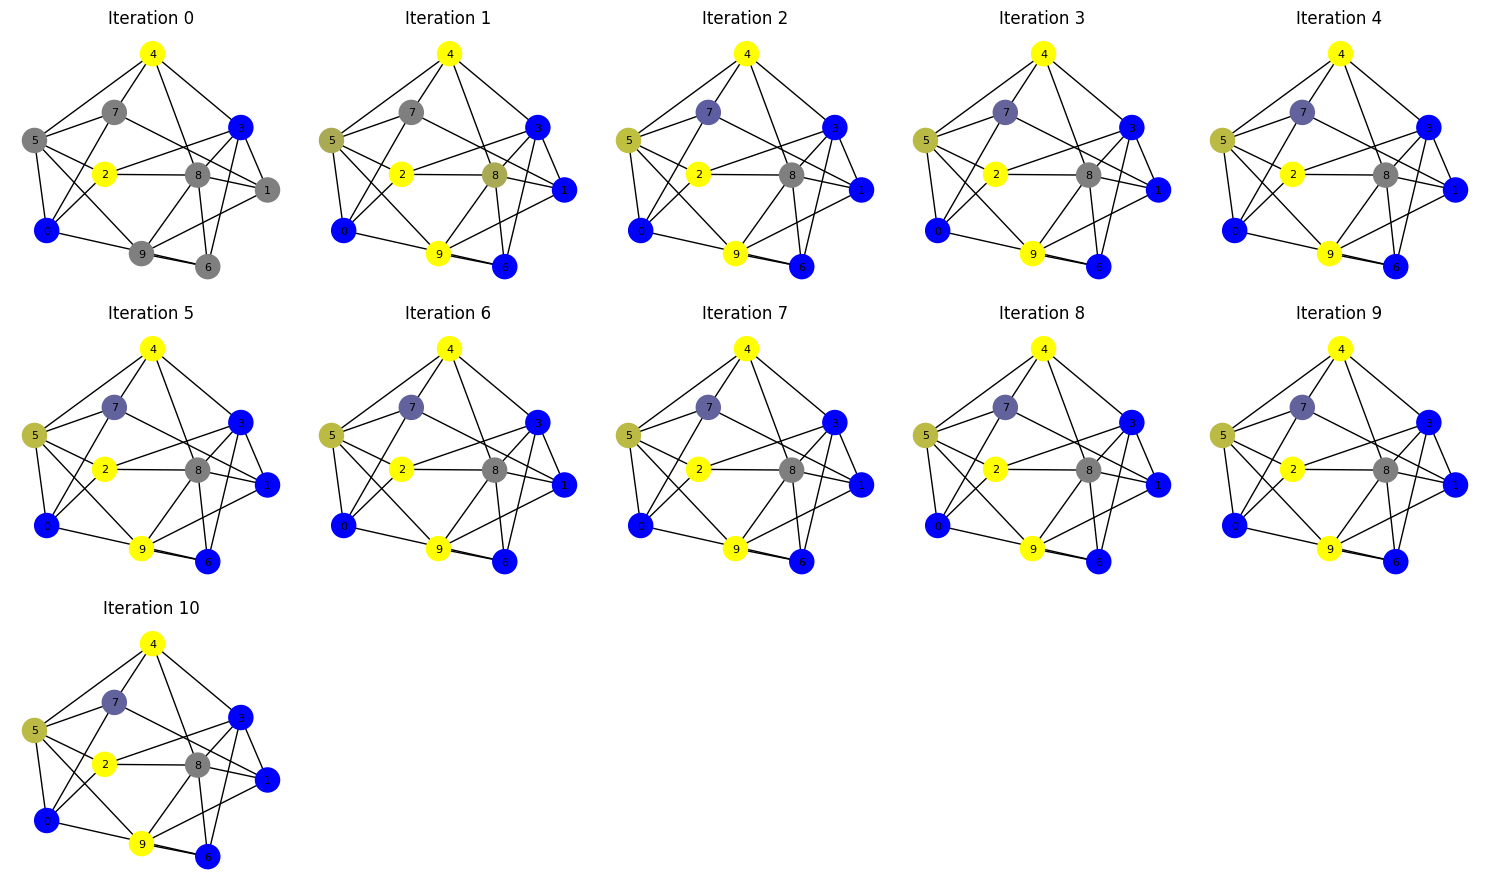

In [90]:
"""
    num_nodes: number of nodes to initialize in the graph
    label_prob: percentage of labeled nodes to start with (for example, label_prob=0.2 means 20% of nodes are labeled at the start)
    num_layers: number of message passing iterations to perform
"""
run(num_nodes=10, label_prob=0.2, num_layers=10)